In [1]:
# Library Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pickle
import os
import shutil

sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read available images

imagePath = r'C:\Users\Christopher\Conservation_Labs\images'
trainPath = imagePath + '/train/'
valPath = imagePath + '/test/'

file_list = os.listdir(trainPath)

In [3]:
file_list

['a84_10699_kitsink.jpg',
 'a84_10701_kitsink.jpg',
 'a84_10702_kitsink.jpg',
 'a84_10703_revosm.jpg',
 'a84_11871_kitsink.jpg',
 'a84_11875_toilet.jpg',
 'a84_11878_shower.jpg',
 'a84_11879_kitsink.jpg',
 'a84_11880_kitsink.jpg',
 'a84_11930_revosm.jpg',
 'a84_12000_kitsink.jpg',
 'a84_12207_lavsink.jpg',
 'a84_12208_lavsink.jpg',
 'a84_12209_lavsink.jpg',
 'a84_12213_revosm.jpg',
 'a84_12224_lavsink.jpg',
 'a84_12226_lavsink.jpg',
 'a84_12239_lavsink.jpg',
 'a84_12240_lavsink.jpg',
 'a84_12244_lavsink.jpg',
 'a84_12245_lavsink.jpg',
 'a84_12246_lavsink.jpg',
 'a84_12250_kitsink.jpg',
 'a84_13027_kitsink.jpg',
 'a84_13028_kitsink.jpg',
 'a84_13029_kitsink.jpg',
 'a84_13750_kitsink.jpg',
 'a84_13752_kitsink.jpg',
 'a84_13754_kitsink.jpg',
 'a84_13781_revosm.jpg',
 'a84_13821_kitsink.jpg',
 'a84_13823_kitsink.jpg',
 'a84_13966_lavsink.jpg',
 'a84_13969_revosm.jpg',
 'a84_13977_lavsink.jpg',
 'a84_13978_lavsink.jpg',
 'a84_13990_lavsink.jpg',
 'a84_13993_lavsink.jpg',
 'a84_13994_lavsink

In [4]:
obs = pd.Series(file_list[:-2]).apply(lambda x:x.split('.')[0].split('_')[2])

In [5]:
obs.value_counts()

kitsink       864
lavsink       443
revosm        395
toilet        261
shower        102
washer         31
dishwasher     28
dtype: int64

In [6]:
obs.unique()

array(['kitsink', 'revosm', 'toilet', 'shower', 'lavsink', 'washer',
       'dishwasher'], dtype=object)

In [10]:
#os.mkdir(imagePath + 'train')
#os.mkdir(imagePath + 'test')

In [23]:
# Split test files

# for o in obs.unique():
#     temp = obs[obs==o]
#     test_num = int(np.ceil(len(temp)*0.20))
#     test_idx = np.random.choice(temp.index, size=test_num, replace=False)
#     test_files = pd.Series(file_list)[test_idx]
#     for f in test_files:
#         shutil.move(imagePath+f, imagePath+'test/'+f)

In [24]:
# Move train files

# train_image_list = pd.Series(os.listdir(imagePath))[pd.Series(os.listdir(imagePath)).str.contains('.jpg')]
# for f in train_image_list:
#     shutil.move(imagePath+f, imagePath+'train/'+f)

In [30]:
np.random.choice(obs[obs=='kitsink'].index, size=3)

array([449, 421, 653], dtype=int64)

In [8]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from mlxtend.evaluate import accuracy_score as mlaccuracy
import imageio
import matplotlib as mpl
from matplotlib import pyplot as plt 
import os
import cv2
import numpy as np
import math
import random
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

In [9]:
def ohe(label_array):
    encShape = (label_array.size, len(pd.Series(label_array).unique()))
    encRows = np.arange(encShape[0])
    uni,pos = np.unique(label_array, return_inverse=True)
    label_arrayEnc = np.zeros(encShape)
    label_arrayEnc[encRows, pos] = 1
    return label_arrayEnc, uni

In [10]:
# Pull images into list and encode labels for train/validation

trainPath = imagePath + '/train/'
valPath = imagePath + '/test/'

trainImgs = pd.Series(list(os.listdir(trainPath)))
trainLabels = np.array(trainImgs.apply(lambda x:x.split('_')[2].split('.')[0]))
#trainLabelsEnc = ohe.fit_transform(trainLabels)
trainLabelsEnc, trainLabSeq = ohe(trainLabels)

valImgs = pd.Series(list(os.listdir(valPath)))
valLabels = np.array(valImgs.apply(lambda x:x.split('_')[2].split('.')[0]))
#valLabelsEnc = ohe.fit_transform(valLabels)
valLabelsEnc, valLabSeq = ohe(valLabels)

In [11]:
print('One hot encoding sequences:\n', trainLabSeq, '\n', valLabSeq)

One hot encoding sequences:
 ['dishwasher' 'kitsink' 'lavsink' 'revosm' 'shower' 'toilet' 'washer'] 
 ['dishwasher' 'kitsink' 'lavsink' 'revosm' 'shower' 'toilet' 'washer']


In [12]:
valLabelsEnc[:10]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

In [13]:
valLabels[:10]

array(['kitsink', 'kitsink', 'kitsink', 'shower', 'shower', 'kitsink',
       'revosm', 'kitsink', 'lavsink', 'lavsink'], dtype=object)

In [14]:
trainLabelsEnc[:10]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]])

In [15]:
trainLabels[:10]

array(['kitsink', 'kitsink', 'kitsink', 'revosm', 'kitsink', 'toilet',
       'shower', 'kitsink', 'kitsink', 'revosm'], dtype=object)

In [17]:
valImgs

0      a84_10700_kitsink.jpg
1      a84_11873_kitsink.jpg
2      a84_12002_kitsink.jpg
3       a84_12248_shower.jpg
4       a84_12249_shower.jpg
               ...          
532      h641_917_toilet.jpg
533      h641_927_toilet.jpg
534      h641_945_revosm.jpg
535      h641_995_revosm.jpg
536      h641_997_toilet.jpg
Length: 537, dtype: object

In [18]:
trainImgs

0       a84_10699_kitsink.jpg
1       a84_10701_kitsink.jpg
2       a84_10702_kitsink.jpg
3        a84_10703_revosm.jpg
4       a84_11871_kitsink.jpg
                ...          
2121     h641_993_lavsink.jpg
2122     h641_994_kitsink.jpg
2123      h641_996_revosm.jpg
2124     h641_998_lavsink.jpg
2125      h641_999_toilet.jpg
Length: 2126, dtype: object

In [19]:
pd.Series(trainLabels).unique()

array(['kitsink', 'revosm', 'toilet', 'shower', 'lavsink', 'washer',
       'dishwasher'], dtype=object)

In [20]:
trainOcc = pd.Series(trainLabels).value_counts()/(pd.Series(trainLabels).value_counts().sum())

In [13]:
def read_data(image_name, path):
    img = cv2.imread(str(path)+'{}'.format(image_name))
    label = image_name.split('_')[2].split('.')[0]
    return img, label
    
def resize(img):
    new_dim = (800,54)
    resized = cv2.resize(img, new_dim, interpolation = cv2.INTER_AREA)
    return resized

def normalize(img):
    min = img.min()
    max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0

def preprocess_img(img, dim):
    new_dim = dim
    img = cv2.resize(img, new_dim, interpolation = cv2.INTER_AREA)
    min = img.min(); max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0


In [14]:
print('Train path:', trainPath)
print('Val path:', valPath)

Train path: C:\Users\Christopher\Conservation_Labs\images/train/
Val path: C:\Users\Christopher\Conservation_Labs\images/test/


In [15]:
img, label = read_data(trainImgs[7], path=trainPath)

(-0.5, 863.5, 863.5, -0.5)

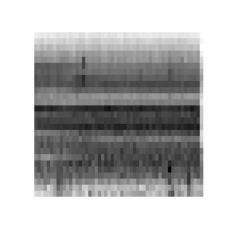

In [16]:
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 53.5, -0.5)

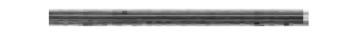

In [25]:
plt.imshow(resize(img))
plt.axis('off')

In [17]:
# Define input shapes
dim = (800,54)

imgR = preprocess_img(img, dim)
img_x = np.shape(imgR)[0]
img_y = np.shape(imgR)[1]
img_z = np.shape(imgR)[2]

inputs = np.array([img_x, img_y, img_z])
print(inputs)

[ 54 800   3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 799.5, 53.5, -0.5)

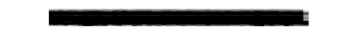

In [27]:
plt.imshow(imgR)
plt.axis('off')

In [28]:
print('Classification:', label)
print('Image Shape:', np.shape(img))
print('PreProcessed Image Shape:', np.shape(preprocess_img(img, dim)))

Classification: kitsink
Image Shape: (864, 864, 3)
PreProcessed Image Shape: (54, 800, 3)


In [18]:
def cnn_model(inputs, n_classes):
    inputs = Input((inputs[0], inputs[1], inputs[2]))
    conv1 = (Conv2D(32, kernel_size=(3, 3), activation='relu'))(inputs)
    conv2 = (Conv2D(64, kernel_size=(3, 3), activation='relu'))(conv1)
    pool1 = (MaxPooling2D(pool_size=(2, 2)))(conv2)
    dropout1 = (Dropout(0.25))(pool1)
    flatten = (Flatten())(dropout1)
    dense1 = (Dense(32, activation='relu'))(flatten)
    dropout2 = (Dropout(0.5))(dense1)
    output = (Dense(n_classes, activation='softmax'))(dropout2)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

In [19]:
print(inputs)

[ 54 800   3]


In [31]:
pd.Series(trainLabels).value_counts()

kitsink       864
lavsink       444
revosm        395
toilet        262
shower        102
washer         31
dishwasher     28
dtype: int64

In [32]:
len(pd.Series(trainLabels).unique())

7

In [20]:
n_classes=len(pd.Series(trainLabels).unique())
cnn = cnn_model(inputs=inputs, n_classes=n_classes)

In [34]:
print(cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 54, 800, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 52, 798, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 796, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 398, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 398, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 636800)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                203776

In [35]:
# Define model parameters
ts = datetime.now()
ts_str = ts.strftime("%d%b%H%M")
n_epochs = 50
batch_size = 32
train_size = 350
val_size = 70
train_iters = 50
counter = 0
model_checkpoint = ModelCheckpoint(filepath='model_outputs/{}_ConsLabsCNN.hdf5'.format(ts_str), 
                                   monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('model_outputs/{}_log.csv'.format(ts_str), append=True, separator=';')
tensorboard = TensorBoard(log_dir='model_outputs/tensorboard_ConsLabs_CNN\\', write_graph=True, write_images=True,
                         profile_batch = 100000000)

In [36]:
trainQty = np.rint(train_size*trainOcc)
valQty = np.rint(val_size*trainOcc)
totalQty = trainQty + valQty
print('Train Iter Size: {0}\nVal Iter Size: {1}\nTotal Iter Size: {2}'.format(trainQty.sum(), valQty.sum(), totalQty.sum()))

Train Iter Size: 350.0
Val Iter Size: 70.0
Total Iter Size: 420.0


In [37]:
dim

(800, 54)

In [21]:
# Separate events/fixtures to use for randomly fitting each iter
trainEvents = pd.Series(trainLabels)
valEvents = pd.Series(valLabels)
fixtures = trainEvents.unique()

In [82]:
print('Train Image Dir =', trainPath)
print('Val Image Dir =', valPath)

# Train model
while counter < train_iters:
    print('\n***Train iteration {}\n'.format(counter+1))
    
    # Build empty arrays for compiling images
    x_train = list()#np.empty(shape=(0,img_x,img_y,img_z))
    y_train = list()#np.empty(shape=(0,n_classes))
    x_val = list()#np.empty(shape=(0,img_x,img_y,img_z))
    y_val = list()#np.empty(shape=(0,n_classes))
    
    # Iterate through fixtures to make train/val choice based on params
    trainIdx = list()
    valIdx = list()
    for f in fixtures:
        #fixIdx = np.random.choice(events[events == f].index.values, size=int(totalQty.loc[f]), replace = False)
        try:
            vI = np.random.choice(valEvents[valEvents == f].index.values, 
                                  size=int(valQty.sum()/n_classes), replace = False)
        except:
            vI = np.random.choice(valEvents[valEvents == f].index.values, 
                                  size=int(valQty.sum()/n_classes), replace = True)
            
        try:
            trI = np.random.choice(trainEvents[trainEvents == f].index.values, 
                                   size=int(trainQty.sum()/n_classes), replace = False)
        except:
            trI = np.random.choice(trainEvents[trainEvents == f].index.values, 
                                   size=int(trainQty.sum()/n_classes), replace = True)
        
        # Append indexes for train/validation
        trainIdx.append(trI)
        valIdx.append(vI)
        
    for i in np.concatenate(trainIdx, axis=0):
        img,dummy = read_data(trainImgs.iloc[i], path=trainPath)
        imgR = preprocess_img(img, dim)
        lab = trainLabelsEnc[i]
        
        x_train.append(imgR)
        y_train.append(lab)
        
    for i in np.concatenate(valIdx, axis=0):
        img,dummy = read_data(valImgs.iloc[i], path=valPath)
        imgR = preprocess_img(img, dim)
        lab = valLabelsEnc[i]
        
        x_val.append(imgR)
        y_val.append(lab)
        
    
    cnn.fit(np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=n_epochs,
              verbose=1, shuffle=True, callbacks=[model_checkpoint, csv_logger, tensorboard],
              validation_data=(np.array(x_val), np.array(y_val)))
    counter = counter + 1
    

Train Image Dir = ./images/train/
Val Image Dir = ./images/test/

***Train iteration 1

Epoch 1/50
11/11 [==============================] - 35s 3s/step - loss: 0.4648 - val_loss: 0.3721
Epoch 2/50
11/11 [==============================] - 35s 3s/step - loss: 0.4554 - val_loss: 0.3841
Epoch 3/50
11/11 [==============================] - 36s 3s/step - loss: 0.4518 - val_loss: 0.3632
Epoch 4/50
11/11 [==============================] - 37s 3s/step - loss: 0.4412 - val_loss: 0.3482
Epoch 5/50
11/11 [==============================] - 36s 3s/step - loss: 0.4331 - val_loss: 0.3567
Epoch 6/50
11/11 [==============================] - 43s 4s/step - loss: 0.4428 - val_loss: 0.3560
Epoch 7/50
11/11 [==============================] - 35s 3s/step - loss: 0.4342 - val_loss: 0.3409
Epoch 8/50
11/11 [==============================] - 38s 3s/step - loss: 0.4099 - val_loss: 0.3454
Epoch 9/50
11/11 [==============================] - 37s 3s/step - loss: 0.4145 - val_loss: 0.3367
Epoch 10/50
11/11 [===========

Epoch 33/50
11/11 [==============================] - 36s 3s/step - loss: 0.3035 - val_loss: 0.2811
Epoch 34/50
11/11 [==============================] - 36s 3s/step - loss: 0.2895 - val_loss: 0.2744
Epoch 35/50
11/11 [==============================] - 42s 4s/step - loss: 0.3076 - val_loss: 0.2788
Epoch 36/50
11/11 [==============================] - 38s 4s/step - loss: 0.2965 - val_loss: 0.2890
Epoch 37/50
11/11 [==============================] - 40s 4s/step - loss: 0.3118 - val_loss: 0.2902
Epoch 38/50
11/11 [==============================] - 40s 4s/step - loss: 0.3041 - val_loss: 0.2857
Epoch 39/50
11/11 [==============================] - 38s 3s/step - loss: 0.2935 - val_loss: 0.2900
Epoch 40/50
11/11 [==============================] - 37s 3s/step - loss: 0.3026 - val_loss: 0.2923
Epoch 41/50
11/11 [==============================] - 36s 3s/step - loss: 0.3018 - val_loss: 0.3022
Epoch 42/50
11/11 [==============================] - 36s 3s/step - loss: 0.2805 - val_loss: 0.2923
Epoch 43/5

KeyboardInterrupt: 

In [243]:
cnn.save('model_outputs/{}_cnn.h5'.format(ts_str))

In [26]:
# Compile all images for train/validation evaluation
x_train = list()#np.empty(shape=(0,img_x,img_y,img_z))
y_train = list()#np.empty(shape=(0,n_classes))
x_val = list()#np.empty(shape=(0,img_x,img_y,img_z))
y_val = list()#np.empty(shape=(0,n_classes))

# Iterate through fixtures to make train/val choice based on params
trainIdx = list()
valIdx = list()

trI = trainEvents.index.values
vI = valEvents.index.values

# Append indexes for train/validation
trainIdx.append(trI)
valIdx.append(vI)
hoIdx.append(hoI)

for i in np.concatenate(trainIdx, axis=0):
    img,dummy = read_data(trainImgs.iloc[i], path=trainPath)
    imgR = preprocess_img(img, dim)
    lab = trainLabelsEnc[i]

    x_train.append(imgR)
    y_train.append(lab)

for i in np.concatenate(valIdx, axis=0):
    img,dummy = read_data(valImgs.iloc[i], path=valPath)
    imgR = preprocess_img(img, dim)
    lab = valLabelsEnc[i]

    x_val.append(imgR)
    y_val.append(lab)

In [22]:
print('Training shape:\n*** x_train: {0}\n*** y_train: {1}'.format(np.shape(x_train), np.shape(y_train)))
print('Validation shape:\n*** x_val: {0}\n*** y_val: {1}'.format(np.shape(x_val), np.shape(y_val)))

Training shape:
*** x_train: (2126, 54, 800, 3)
*** y_train: (2126, 7)
Validation shape:
*** x_val: (537, 54, 800, 3)
*** y_val: (537, 7)


In [26]:
### Evaluation on 4-25
output_path = r'C:\Users\Christopher\Conservation_Labs\model_outputs/'
model_eval = cnn_model(inputs=inputs, n_classes=n_classes)
model_eval.load_weights(output_path+'/25Apr1740_ConsLabsCNN.hdf5')

In [27]:
trainScore = model_eval.evaluate(np.array(x_train), np.array(y_train), verbose=0)
trainPred = model_eval.predict(np.array(x_train))

valScore = model_eval.evaluate(np.array(x_val), np.array(y_val), verbose=0)
valPred = model_eval.predict(np.array(x_val))

In [28]:
y_pred_train = (trainPred == trainPred.max(axis=1)[:,None]).astype(int)
y_pred_val = (valPred == valPred.max(axis=1)[:,None]).astype(int)

In [30]:
print('Train loss:', trainScore)
print('Train accuracy:', mlaccuracy(np.array(y_train), y_pred_train))
print('Avg. train accuracy by class:',\
      mlaccuracy(np.array(y_train), trainPred, method='average'))

print('\nValidation loss:', valScore)
print('Validation accuracy:', mlaccuracy(np.array(y_val), y_pred_val))
print('Avg. validation accuracy by class:',\
      mlaccuracy(np.array(y_val), valPred, method='average'))

Train loss: 3.336362600326538
Train accuracy: 0.9885768041929848
Avg. train accuracy by class: 0.6264950947453299

Validation loss: 3.277759552001953
Validation accuracy: 0.9702048417132216
Avg. validation accuracy by class: 0.6086725192870445


In [22]:
output_path = r'C:\Users\Christopher\Conservation_Labs\model_outputs/'
model_eval = cnn_model(inputs=inputs, n_classes=n_classes)
model_eval.load_weights(output_path+'/25Apr1949_ConsLabsCNN.hdf5')

In [57]:
results = model_eval.evaluate(np.array(x_train), np.array(y_train))

67/67 [==============================] - 44s 656ms/step - loss: 5.3918


In [33]:
trainScore = model_eval.evaluate(np.array(x_train), np.array(y_train), verbose=0)
trainPred = model_eval.predict(np.array(x_train))

valScore = model_eval.evaluate(np.array(x_val), np.array(y_val), verbose=0)
valPred = model_eval.predict(np.array(x_val))

In [34]:
y_pred_train = (trainPred == trainPred.max(axis=1)[:,None]).astype(int)
y_pred_val = (valPred == valPred.max(axis=1)[:,None]).astype(int)

In [36]:
print('Train loss:', trainScore)
print('Train accuracy:', mlaccuracy(np.array(y_train), np.array(y_pred_train)))
print('Avg. train accuracy by class:',\
      mlaccuracy(np.array(y_train), y_pred_train, method='average'))

print('\nValidation loss:', valScore)
print('Validation accuracy:', mlaccuracy(np.array(y_val), np.array(y_pred_val)))
print('Avg. validation accuracy by class:',\
      mlaccuracy(np.array(y_val), y_pred_val, method='average'))

Train loss: 4.80530309677124
Train accuracy: 0.9986560946109394
Avg. train accuracy by class: 0.9986560946109394

Validation loss: 4.520874977111816
Validation accuracy: 0.979781856876829
Avg. validation accuracy by class: 0.979781856876829


In [23]:
from sklearn.metrics import classification_report

In [47]:
trainLabSeq

array(['dishwasher', 'kitsink', 'lavsink', 'revosm', 'shower', 'toilet',
       'washer'], dtype=object)

In [49]:
print('*** Training set classification report:\n')
print(classification_report(np.array(y_train), np.array(y_pred_train), target_names=trainLabSeq))
print('\n*** Validation set classification report:\n')
print(classification_report(np.array(y_val), np.array(y_pred_val), target_names=trainLabSeq))

*** Training set classification report:

              precision    recall  f1-score   support

  dishwasher       0.93      1.00      0.97        28
     kitsink       1.00      0.99      0.99       864
     lavsink       1.00      1.00      1.00       444
      revosm       0.99      1.00      0.99       395
      shower       0.98      1.00      0.99       102
      toilet       1.00      1.00      1.00       262
      washer       1.00      1.00      1.00        31

   micro avg       1.00      1.00      1.00      2126
   macro avg       0.99      1.00      0.99      2126
weighted avg       1.00      1.00      1.00      2126
 samples avg       1.00      1.00      1.00      2126


*** Validation set classification report:

              precision    recall  f1-score   support

  dishwasher       0.67      0.50      0.57         8
     kitsink       0.93      0.93      0.93       217
     lavsink       0.97      0.97      0.97       112
      revosm       0.92      0.97      0.95    

In [95]:
uni,pos = np.unique(trainLabSeq, return_inverse=True)
print(uni)
print(pos)

['dishwasher' 'kitsink' 'lavsink' 'revosm' 'shower' 'toilet' 'washer']
[0 1 2 3 4 5 6]


In [40]:
encodings,seq = ohe(trainLabSeq)
encodings

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [40]:
for count,j in enumerate(encodings):
    print(j, trainLabSeq[count])

[1. 0. 0. 0. 0. 0. 0.] dishwasher
[0. 1. 0. 0. 0. 0. 0.] kitsink
[0. 0. 1. 0. 0. 0. 0.] lavsink
[0. 0. 0. 1. 0. 0. 0.] revosm
[0. 0. 0. 0. 1. 0. 0.] shower
[0. 0. 0. 0. 0. 1. 0.] toilet
[0. 0. 0. 0. 0. 0. 1.] washer


In [54]:
y_pred_train_labs = []
for i in y_pred_train:
    for count,j in enumerate(encodings):
        if np.min(i == j) == True:
            y_pred_train_labs.append(trainLabSeq[count])

In [112]:
pd.Series(y_pred_train_labs).shape

(2126,)

In [114]:
trainLabels

(2126,)

In [55]:
trainCM = confusion_matrix(trainLabels, y_pred_train_labs)
trainCM

array([[ 28,   0,   0,   0,   0,   0,   0],
       [  2, 854,   0,   5,   2,   1,   0],
       [  0,   0, 444,   0,   0,   0,   0],
       [  0,   0,   0, 395,   0,   0,   0],
       [  0,   0,   0,   0, 102,   0,   0],
       [  0,   0,   0,   0,   0, 262,   0],
       [  0,   0,   0,   0,   0,   0,  31]], dtype=int64)

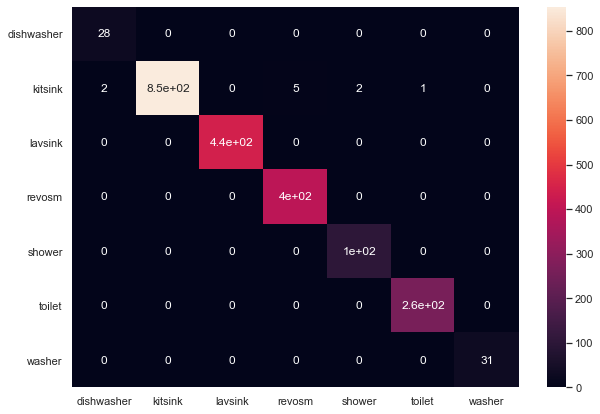

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(trainCM, index = [i for i in trainLabSeq],
                      columns = [i for i in trainLabSeq])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [57]:
y_pred_val_labs = []
for i in y_pred_val:
    for count,j in enumerate(encodings):
        if np.min(i == j) == True:
            y_pred_val_labs.append(trainLabSeq[count])

In [58]:
valCM = confusion_matrix(valLabels, y_pred_val_labs)
valCM

array([[  4,   4,   0,   0,   0,   0,   0],
       [  2, 202,   1,   6,   5,   1,   0],
       [  0,   3, 109,   0,   0,   0,   0],
       [  0,   3,   0,  96,   0,   0,   0],
       [  0,   3,   0,   1,  21,   2,   0],
       [  0,   2,   2,   1,   1,  59,   1],
       [  0,   0,   0,   0,   0,   0,   8]], dtype=int64)

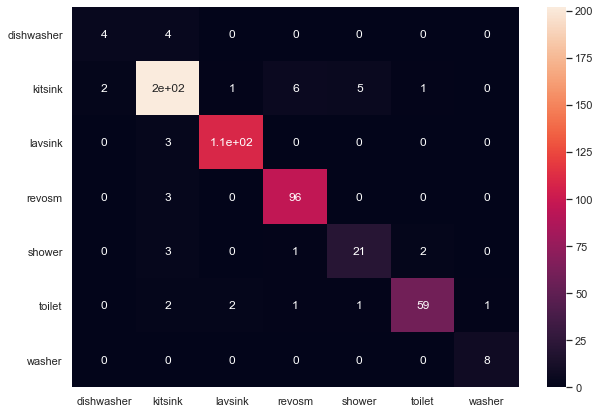

In [59]:
df_cm = pd.DataFrame(valCM, index = [i for i in trainLabSeq],
                      columns = [i for i in trainLabSeq])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)